In [1]:
from PIL import Image,  ImageDraw
import numpy as np
import math
import heapq
import matplotlib.pyplot as plt
from Modules.Kalman import ekf
# from Kalman_Julien import ekf
import time
import Modules.Path_planning as Path_planning
import Modules.Control as Control
from Modules.ThymioVision import ThymioVision

In [2]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [3]:
leds_circle = [32, 32, 0, 0, 0, 0, 0, 32]

# Global Map 

In [ ]:
map = "./img/map2.png"

In [ ]:
def convert_image_to_binary_array(image_path,target_size=(1091, 772)):
    # Load the image
    image = Image.open(image_path)

    resized_image = image.resize(target_size)

    # Convert the image to grayscale
    resized_image = resized_image.convert("L")

    # Set the binary threshold
    binary_threshold = 128

    # Convert grayscale to binary image
    bw_image = resized_image.point(lambda p: p < binary_threshold and 1)

    # Convert image to numpy array
    binary_matrix = np.array(bw_image)
    return binary_matrix , resized_image

In [ ]:
class NODE:
    def __init__(self, position, g=float('inf'), h=0, parent=None):
        self.position = position
        self.g = g
        self.h = h
        self.f = g + h
        self.parent = parent

    # Nodes will be compared based on their f value, we use this because of the heapq
    def __lt__(self, other):
        return self.f < other.f

    # Function to represent the node
    def __repr__(self):
        return f"Node(position={self.position}, g={self.g}, h={self.h}, f={self.f})"

    @staticmethod
    def reconstruct_path(node):
        path = []
        while node:
            path.append(node.position)
            node = node.parent
        return path[::-1]


# Heuristic function using Octile distance (allowing 8 directions of movement)
def Heuristic_function(node, goal):
    dx = abs(node.position[0] - goal.position[0])
    dy = abs(node.position[1] - goal.position[1])
    return max(dx, dy) + (math.sqrt(2) - 1) * min(dx, dy)

def A_star(environment_map, START_POSITION, GOAL_POSITION):

    START_NODE = NODE(START_POSITION, g=0)
    GOAL_NODE = NODE(GOAL_POSITION)

    START_NODE.h = Heuristic_function(START_NODE, GOAL_NODE)
    START_NODE.f = START_NODE.g + START_NODE.h

    # Initialize the open and closed lists
    OPEN_list = []
    heapq.heappush(OPEN_list, START_NODE)
    CLOSED_set = set()

    # Dictionary to keep track of nodes
    nodes = {}
    nodes[tuple(START_NODE.position)] = START_NODE

    while OPEN_list:
        # Pop the node with the lowest f value
        CURRENT_NODE = heapq.heappop(OPEN_list)

        # If the current node is in the closed set, skip it
        if tuple(CURRENT_NODE.position) in CLOSED_set:
            continue

        # Add the current node's position to the closed set
        CLOSED_set.add(tuple(CURRENT_NODE.position))

        # If the current node is the goal, reconstruct the path
        if CURRENT_NODE.position == GOAL_NODE.position:
            path = NODE.reconstruct_path(CURRENT_NODE)
            print("Path found:", path)
            return path

        # Possible moves: 8 directions (including diagonals)
        MOVES = [[1, 0], [0, 1], [-1, 0], [0, -1],
                 [1, 1], [-1, -1], [1, -1], [-1, 1]]

        # Explore neighbors
        for move in MOVES:
            neighbor_position = [CURRENT_NODE.position[0] + move[0],
                                 CURRENT_NODE.position[1] + move[1]]
            neighbor_pos = tuple(neighbor_position)

            # Skip if out of bounds or obstacle
            if (neighbor_position[0] < 0 or neighbor_position[0] >= environment_map.shape[0] or
                neighbor_position[1] < 0 or neighbor_position[1] >= environment_map.shape[1] or
                environment_map[neighbor_position[0], neighbor_position[1]] == 1):
                continue

            # Skip if in closed set
            if neighbor_pos in CLOSED_set:
                continue

            # Calculate movement cost (diagnoal movement cost is sqrt(2))
            dx = abs(move[0])
            dy = abs(move[1])
            movement_cost = math.sqrt(2) if dx == 1 and dy == 1 else 1

            g_tentative = CURRENT_NODE.g + movement_cost

            # Create or get the neighbor node
            if neighbor_pos not in nodes:
                neighbor_node = NODE(neighbor_position)
                nodes[neighbor_pos] = neighbor_node
            else:
                neighbor_node = nodes[neighbor_pos]

            # If this path to neighbor is better, record it
            if g_tentative < neighbor_node.g:
                neighbor_node.g = g_tentative
                neighbor_node.h = Heuristic_function(neighbor_node, GOAL_NODE)
                neighbor_node.f = neighbor_node.g + neighbor_node.h
                neighbor_node.parent = CURRENT_NODE

                # Add the neighbor to the open list
                heapq.heappush(OPEN_list, neighbor_node)

    print("No path found.")
    return None

In [ ]:
binary_matrix , resized_image = convert_image_to_binary_array(map)
# Start and goal positions
START_POSITION = [5, 5]
GOAL_POSITION = [760, 1080]

path = A_star(binary_matrix, START_POSITION, GOAL_POSITION)


AttributeError: 'tuple' object has no attribute 'read'

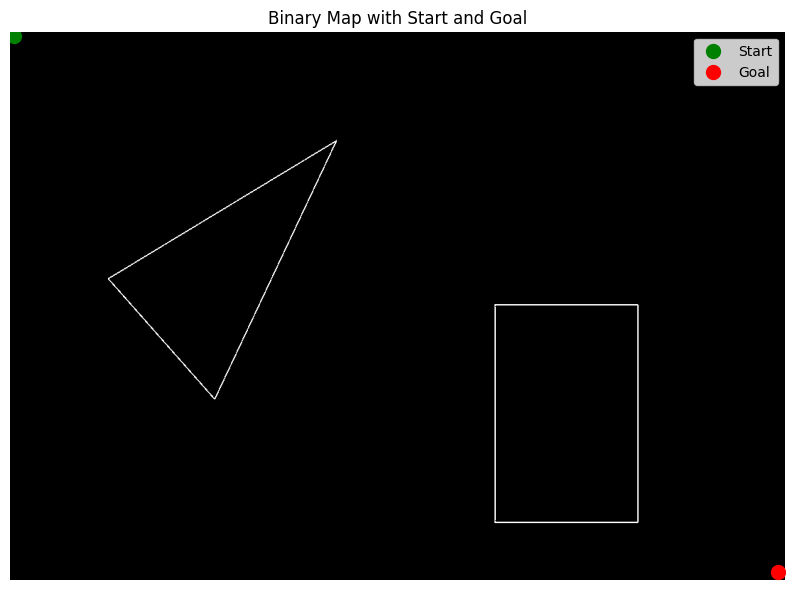

In [ ]:
# Display the binary map with start and goal points
plt.figure(figsize=(10, 10))
plt.imshow(binary_matrix, cmap="gray")
plt.scatter(START_POSITION[1], START_POSITION[0], color='green', s=100, label="Start")  # Green for Start
plt.scatter(GOAL_POSITION[1], GOAL_POSITION[0], color='red', s=100, label="Goal")  # Red for Goal
plt.title("Binary Map with Start and Goal")
plt.legend()
plt.axis("off")
plt.show()


PIL and Matplotlib have different systems of coordinates. Pillow treats the top-left corner as (0,0), and coordinates increase downwards and rightwards.While for Matplotlib displays images as NumPy arrays, where the origin is at the bottom-left corner, and the y-axis is flipped compared to Pillow.

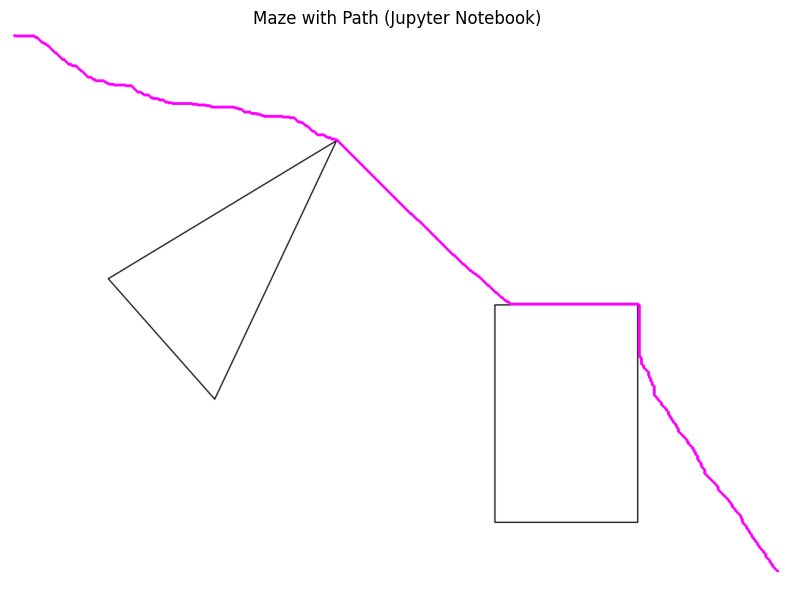

In [ ]:
def swap_path_coordinates(path_coordinates):
    swapped_path = [[y, x] for x, y in path_coordinates]
    return swapped_path

def display_path(maze_img, path):

    # Convert the maze image to RGB (to draw in color)
    maze_img = maze_img.convert("RGB")

    # Swap path coordinates to match PIL's (x, y) format
    path = swap_path_coordinates(path)

    # Create a drawing object
    draw = ImageDraw.Draw(maze_img)

    # Draw the path (magenta line)
    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        draw.line((x1, y1, x2, y2), fill=(255, 0, 255), width=4)  # Magenta line with width 4

    # Save the modified image (optional)
    #maze_img.save("maze_with_path_fixed.png")

    # Display the image using Matplotlib
    maze_array = np.array(maze_img)  # Convert to NumPy array for Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(maze_array)
    plt.axis("off")
    plt.title("Maze with Path (Jupyter Notebook)")
    plt.show()

display_path(resized_image, path)

In [ ]:
def segment_path(path, step=10):
    """
    Segments the A* path into waypoints for the motion controller.

    Parameters:
    - path: List of (row, column) points from the A* algorithm.
    - step: Number of points to skip between waypoints.

    Returns:
    - waypoints: List of (x, y) waypoints in meters.
    """
    waypoints = path[::step]  # Take every `step`-th point
    waypoints.append(path[-1])  # Ensure the last point (goal) is included
    return waypoints

def grid_to_world_coordinates(waypoints, map_resolution, origin=(0, 0)):
    """
    Converts waypoints from grid coordinates to world coordinates.

    Parameters:
    - waypoints: List of (row, col) waypoints in grid coordinates.
    - map_resolution: Size of each grid cell in meters.
    - origin: World coordinates of the grid's (0, 0).

    Returns:
    - world_waypoints: List of (x, y) waypoints in meters.
    """
    world_waypoints = [
        (origin[0] + w[1] * map_resolution, origin[1] + w[0] * map_resolution) for w in waypoints
    ]
    return world_waypoints


In [ ]:
waypoints = segment_path(path, step=40) 
map_resolution = 0.05  
origin = (0, 0)
world_waypoints = grid_to_world_coordinates(waypoints, map_resolution, origin)

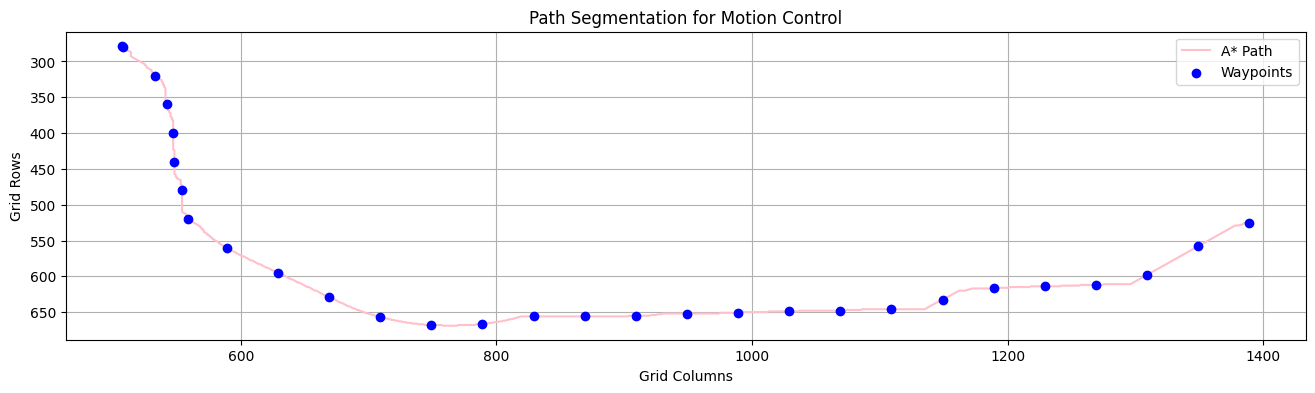

In [ ]:
path = np.array(path)
plt.plot(path[:, 1], path[:, 0], label="A* Path", color="pink")

waypoints = np.array(waypoints)
plt.scatter(waypoints[:, 1], waypoints[:, 0], color="blue", label="Waypoints", zorder=3)

plt.gca().invert_yaxis()  
plt.legend()
plt.title("Path Segmentation for Motion Control")
plt.xlabel("Grid Columns")
plt.ylabel("Grid Rows")
plt.grid()
plt.show()


# Motion Control 

## Testing some things on thymio: 

In [ ]:
!pip install --upgrade tdmclient

In [4]:
# Robot-specific constants
ROBOT_CENTER_TO_WHEEL = 47.5  # Half the wheelbase mm
ROBOT_WHEEL_RADIUS = 22    # Radius of the wheels mm
SPEED_THRESHOLD = 100         # Max Thymio wheel speed

# Normalize angle to (-pi, pi)
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Astolfi Controller for Thymio
def astolfi_controller(state, goal, kr= 0.8, ka=  1.2,  goal_tolerance=20):
    #alpha doit etre plus grand que rho pour Julien 
    
    x = state[0] #en mm 
    y = state[1] #en mm 
    theta = state[2]
    x_goal, y_goal = goal
    dx = x_goal - x
    dy = -(y_goal - y)
    rho = np.sqrt(dx**2 + dy**2)  # Distance to goal

    # print ("Distance to goal = " , rho )

    # alpha = -normalize_angle(np.arctan2(dy, dx) - theta)
    alpha = (np.arctan2(dy, dx) - theta)
    #beta = normalize_angle(- theta - alpha)

    # Stop if the robot is close enough to the goal
    if rho < goal_tolerance:
        return 0.0, 0.0, True
    # Control laws
    v = kr * rho #kr > 0 
    #v = max(kr * rho, MIN_SPEED) 
    omega = ka * alpha 
    return v, omega, False


# Convert velocities to motor speeds
def compute_motor_speeds(v, omega):

    # Convert speed thresholds for clipping
    max_v = SPEED_THRESHOLD * 0.388  # Max linear velocity in mm/s
    max_omega = max_v / ROBOT_CENTER_TO_WHEEL  # Max angular velocity in rad/s

    v = np.clip(v, -max_v, max_v) #actul control velocity given to the thymio 
    omega = np.clip(omega, -max_omega, max_omega)

    right_wheel_mm_s = (v + omega * ROBOT_CENTER_TO_WHEEL)  # mm/s
    left_wheel_mm_s = (v - omega * ROBOT_CENTER_TO_WHEEL)  # mm/s

    thymio_speed_to_mms = 0.388
    right_wheel_enc = np.clip(right_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)
    left_wheel_enc = np.clip(left_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)

    # # Debugging outputs
    # print(f"Clipped control inputs: v = {v}, omega = {omega}")
    # print(f"left wheel control speed = {left_wheel_enc}, right wheel control speed = {right_wheel_enc}")

    return int(left_wheel_enc), int(right_wheel_enc) , v , omega 


## TEST 

In [5]:
#fonctions de Julie 
@tdmclient.notebook.sync_var 
def set_speed(right_speed,left_speed):
    global motor_right_target, motor_left_target
    motor_right_target=right_speed
    motor_left_target=left_speed

@tdmclient.notebook.sync_var
def stop_thymio():
    global motor_right_target,motor_left_target
    motor_right_target=0
    motor_left_target=0

@tdmclient.notebook.sync_var
def get_speed():
    global motor_right_speed, motor_left_speed
    return motor_right_speed,motor_left_speed

def speed_convesion(r_speed,l_speed):
    thymio_speed_to_mms = 0.388 # value found in covariance_estimation

    #odometry 
    avg_thymio_speed = (r_speed + l_speed) / 2
    speed = avg_thymio_speed * thymio_speed_to_mms # [mm/s]
    return speed

def angular_vel_conversion(r_speed,l_speed):
    d = 95 # distance between the 2 wheels [mm]
    thymio_speed_to_mms = 0.388 # value found in covariance_estimation
    
    difference_speed = l_speed - r_speed
    omega = difference_speed * thymio_speed_to_mms / d # [rad/s]

    return omega

@tdmclient.notebook.sync_var
def get_proximity_values():
    global prox_horizontal
    prox = prox_horizontal
    prox_front = prox[2]
    prox_left = prox[0]
    prox_left_front = prox[1]
    prox_right_front = prox[3]
    prox_right = prox[4]
    return prox_front, prox_left, prox_left_front, prox_right_front, prox_right


In [6]:
def move_to_waypoint(state, waypoint, goal_tolerance=20):
    # Astolfi controller to compute control signals
    v, omega, reached = astolfi_controller(state, waypoint, goal_tolerance=goal_tolerance)
    if reached:
        return 0, 0, True , 0 ,0
    # Convert control signals to motor speeds
    left_speed, right_speed ,v_f , omega_f = compute_motor_speeds(v, omega)
    return left_speed, right_speed, False , v_f , omega_f  #in Thymio's units 


In [7]:
ThymioVision.calibrateCameraPos(0)

2024-12-04 15:27:12.113 Python[37313:1503173] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


2024-12-04 15:28:41.424 Python[37349:1504454] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


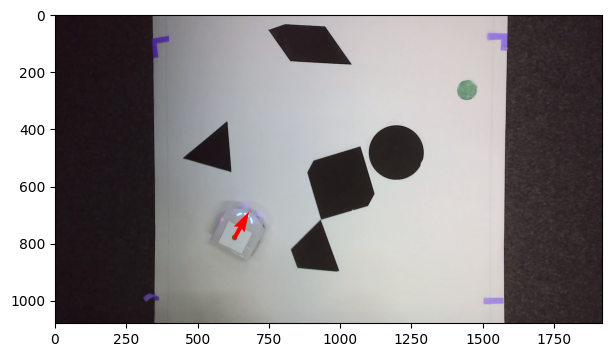

(629, 781, np.float64(1.0659349551357702))

In [7]:
frame = ThymioVision.captureImageOnCommand(0)
ThymioVision.getThymioPose(frame, verbose=True)

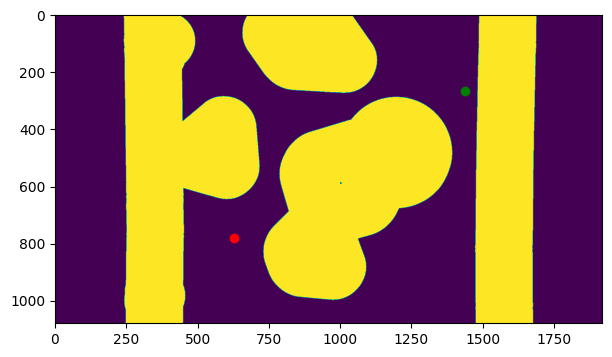

In [8]:
map = ThymioVision.getMap(frame, verbose=True)
obstacles = map[0]
start = map[1]
end = map[2]

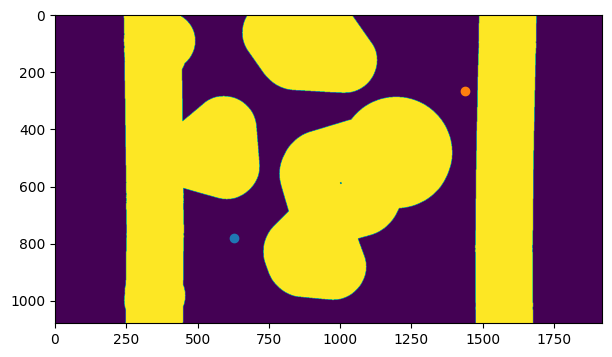

In [9]:
plt.imshow(map[0])
pose = map[1]
goal = map[2]
plt.plot([pose[0]], [pose[1]], 'o')
plt.plot([goal[0]], [goal[1]], 'o')

In [10]:
correctedStart = [start[1], start[0]]
correctedGoal = [end[1], end[0]]
path = Path_planning.A_star(obstacles, correctedStart, correctedGoal)

Path found: [[781, 629], [780, 630], [779, 631], [778, 632], [777, 633], [776, 634], [775, 635], [774, 636], [773, 637], [772, 638], [771, 639], [770, 640], [769, 641], [768, 642], [767, 643], [766, 644], [765, 645], [764, 646], [763, 647], [762, 648], [761, 649], [760, 650], [759, 651], [758, 652], [757, 653], [756, 654], [755, 655], [754, 656], [753, 657], [752, 658], [751, 659], [750, 660], [749, 661], [748, 662], [747, 663], [746, 664], [745, 665], [744, 666], [743, 667], [742, 668], [741, 669], [740, 670], [739, 671], [738, 672], [737, 673], [736, 674], [735, 675], [734, 676], [733, 677], [732, 678], [731, 679], [730, 680], [729, 681], [728, 682], [727, 683], [726, 684], [725, 685], [724, 686], [723, 687], [722, 688], [721, 689], [720, 690], [719, 691], [718, 692], [717, 693], [716, 694], [715, 695], [714, 696], [713, 697], [712, 698], [711, 699], [710, 700], [709, 701], [708, 702], [707, 703], [706, 704], [705, 705], [704, 706], [703, 707], [702, 708], [701, 709], [700, 710], [69

In [11]:
swapped = Path_planning.swap_path_coordinates(path)
waypoints = []
for point in swapped:
    x, y = ThymioVision.pixelToRealSpace(point)
    waypoints.append((x*10, y*10))
waypoints = Control.segment_path(waypoints, step=40)
waypoints

[(201.75, 518.25),
 (231.75, 488.25),
 (261.75, 458.25),
 (291.75, 428.25),
 (318.75, 398.25),
 (318.75, 368.25),
 (319.5, 338.25),
 (327.75, 308.25),
 (344.25, 278.25),
 (373.5, 249.75),
 (403.5, 237.0),
 (433.5, 226.5),
 (463.5, 214.5),
 (493.5, 195.0),
 (523.5, 176.25),
 (553.5, 156.75),
 (583.5, 152.25),
 (613.5, 147.0),
 (643.5, 146.25),
 (673.5, 145.5),
 (703.5, 143.25),
 (733.5, 137.25),
 (763.5, 136.5),
 (793.5, 136.5),
 (808.5, 131.25)]

# NO LOCAL

In [14]:
#pour tester
#waypoints = [(70, 300), (98, 236), (126, 172), (153, 107), (181, 43), (209, -21), (237, -85), (265, -150), (293, -214), (320, -278), (348, -342), (376, -407), (404, -471), (432, -535), (460, -599)]
import cv2
cv2.namedWindow("Camera view")
vc=cv2.VideoCapture(0)
print("vc captured")

state_est=[0,0,0,0,0] 
ret,frame=vc.read()
if ret:
    pose = ThymioVision.getThymioPose(frame) #pixel location of thymio
    obs_camera = ThymioVision.pixelToRealSpace(pose[0:2]) #returns cm, *10 to get mm
    obs_camera = (obs_camera[0]*10, obs_camera[1]*10, pose[2]) #thymio position in mm to give to kalman filter
    state_est=[obs_camera[0],obs_camera[1],obs_camera[2],0,0]   
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])
goal_tolerance = 30


# Logging data
trajectory = [(0,0)]  # To store [x, y] positions
camera_trajectory = [] #trajectory mapped by camera
metrics_rho = []  # Logs for distance to goal
metrics_alpha = []  # Logs for angle to goal
obs_camera=[0,0, 0]
time_prev = time.time()

# Start motion
for waypoint in waypoints:
    actual_time = time.time()
    Ts = actual_time - time_prev
    if Ts < 0.15:
        time.sleep(0.15-Ts)
    time_prev = actual_time

    # prox_front, prox_left, prox_left_front, prox_right_front, prox_right = get_proximity_values()
    # proximity_values = [prox_left, prox_left_front, prox_front, prox_right_front, prox_right]

    print("Goal" , waypoint)
    reached = False
    while not reached:
        ################### CAMERA READ ###################
        ret,frame=vc.read()
        if ret:
            pose = ThymioVision.getThymioPose(frame)#pixel location of thymio
            if pose[0] is not None:
                obs_camera = ThymioVision.pixelToRealSpace(pose[0:2]) #returns cm, *10 to get mm
                obs_camera = (obs_camera[0]*10, obs_camera[1]*10, pose[2]) #thymio position in mm to give to kalman filter
                camera_trajectory.append(obs_camera) #position in mm appended to log
                cv2.circle(frame, (pose[0:2]), 3, (0,255,255),-1) #camera pos
                # convert trajectory onto map
                lastPos = trajectory[-1]
                # lastPos = (lastPos[0]/10 + camera_trajectory[0][0]/10, lastPos[1]/10+camera_trajectory[0][1]/10)
                lastPos = (lastPos[0]/10, lastPos[1]/10)
                pixelPred = ThymioVision.realSpaceToPixel(lastPos)
                cv2.circle(frame, (pixelPred), 3, (0,255,0),-1) #est pos
                cv2.imshow("Camera view", frame)
            key = cv2.waitKey(50)
        if key == ord('q'):
            break
        if pose[0] is None:
            camera_state=False
        else:
            camera_state=True
        print(camera_state)
        
        ################### WAYPOINT FOLLOWING ###################
        input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(state_est, waypoint, goal_tolerance)
        # input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(obs_camera, waypoint, goal_tolerance)

        print("move")

        set_speed(input_right_speed, input_left_speed)
        # Get current odometry data
        r_speed_odo, l_speed_odo = get_speed()
        actual_v = speed_convesion(r_speed_odo, l_speed_odo)
        actual_w = angular_vel_conversion(r_speed_odo, l_speed_odo)
        obs_odometry = [actual_v, actual_w]
        
        ################### UPDATE STATE ESTIMATE ###################

        # Control input
        input_v = v_f #Ca jsp si je remplace par actual_v et actual_w
        input_w = omega_f
        control_vect_prev = [input_v, input_w]

        # Update state with Kalman filter
        print("before)")
        state_est, P_est = ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state,Ts)
        print("after")
        state_est[2]=normalize_angle(state_est[2])
        # Log trajectory
        trajectory.append((state_est[0], state_est[1]))
        
        # Calculate and log metrics
        rho = np.sqrt((waypoint[0] - state_est[0])**2 + (waypoint[1] - state_est[1])**2)
        alpha = normalize_angle(np.arctan2(waypoint[1] - state_est[1], waypoint[0] - state_est[0]) - state_est[2])
        metrics_rho.append(rho)
        metrics_alpha.append(alpha)

        # Print updated state
        # print(ThymioVision.pixelToRealSpace(pose[0:2]))
        print(f"Position Actuelle camera  : x = {obs_camera[0]}, y = {obs_camera[1]}, theta = {obs_camera[2]}") 
        print(f"Position Actuelle odometry: x = {state_est[0]}, y = {state_est[1]}, theta = {state_est[2]}") 

    # Stop the robot at the waypoint
    stop_thymio()
    print(f"Reached waypoint: {waypoint}")

vc.release()
print("Trajectory completed!")


vc captured
Goal (201.75, 518.25)
True
move
before)
eneter
pred
pre-multi
camera
post i
post s
post k
post state
post cov
after
Position Actuelle camera  : x = 203.25, y = 551.25, theta = 1.1224536451182823
Position Actuelle odometry: x = 203.24999971620926, y = 551.2499994025458, theta = 1.12249582579431
True
move
before)
eneter
pred
pre-multi
camera
post i
post s
post k
post state
post cov
after
Position Actuelle camera  : x = 203.25, y = 551.25, theta = 1.1375961583632617
Position Actuelle odometry: x = 203.2500489522758, y = 551.2501021661128, theta = 1.1363277399236802
True
move
before)
eneter
pred
pre-multi
camera
post i
post s
post k
post state
post cov
after
Position Actuelle camera  : x = 204.75, y = 546.75, theta = 1.209355435901344
Position Actuelle odometry: x = 204.71434632899445, y = 546.8573803638251, theta = 1.203164629816781
True
move
before)
eneter
pred
pre-multi
camera
post i
post s
post k
post state
post cov
after
Position Actuelle camera  : x = 204.75, y = 539.25, 

KeyboardInterrupt: 

In [15]:
stop_thymio()

# a

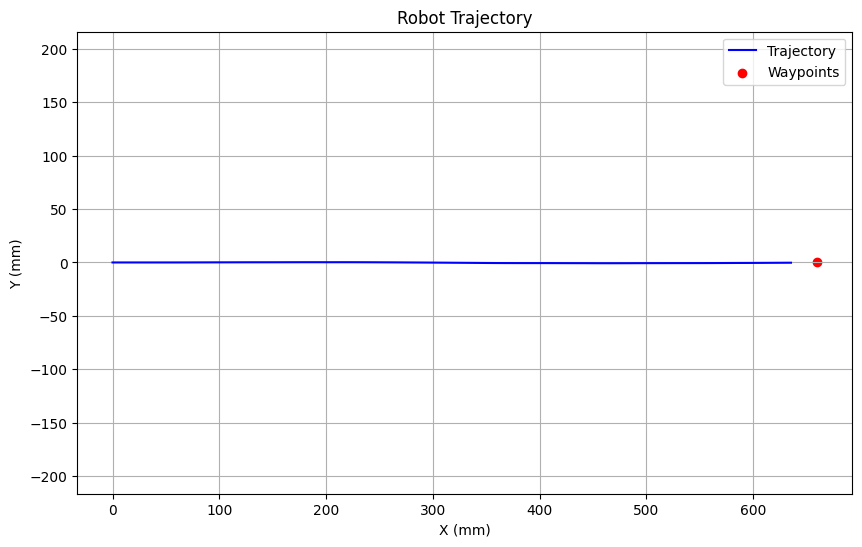

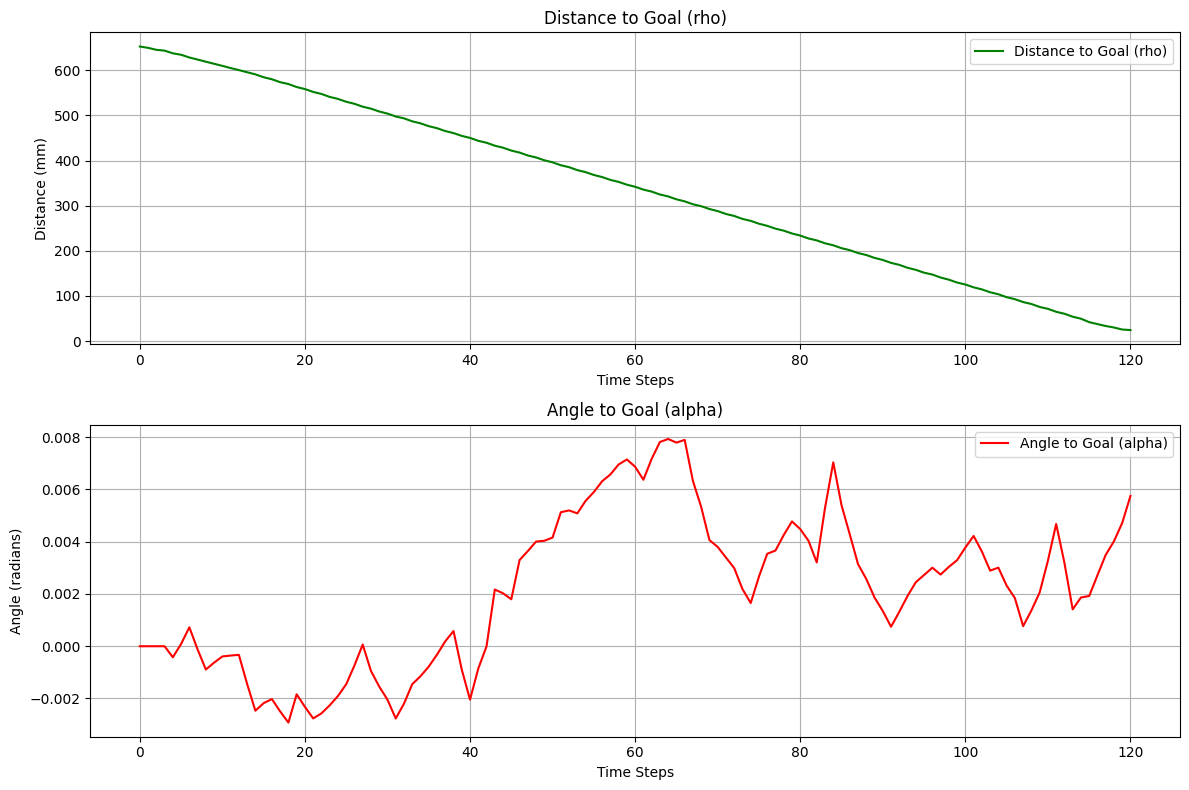

In [ ]:
# Plot the robot's final trajectory
plt.figure(figsize=(10, 6))
plt.title("Robot Trajectory")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
x_coords, y_coords = zip(*trajectory)
plt.plot(x_coords, y_coords, 'b-', label="Trajectory")
plt.scatter(*zip(*waypoints), c='r', label="Waypoints")
plt.axis('equal') #REMOVE
plt.legend()
plt.grid()
plt.show()

# Plot metrics (rho and alpha) over time
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(metrics_rho, 'g-', label="Distance to Goal (rho)")
plt.xlabel("Time Steps")
plt.ylabel("Distance (mm)")
plt.title("Distance to Goal (rho)")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(metrics_alpha, 'r-', label="Angle to Goal (alpha)")
plt.xlabel("Time Steps")
plt.ylabel("Angle (radians)")
plt.title("Angle to Goal (alpha)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
stop_thymio()

In [ ]:
set_speed(100,50)

In [ ]:
leds_circle=[32,32,0,0,0,0,0,32]

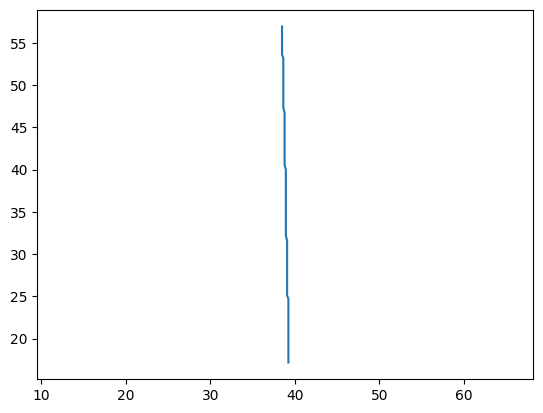

In [ ]:
x_pt = []
y_pt = []
for point in camera_trajectory:
    x_pt.append(point[0])
    y_pt.append(point[1])

plt.axis('equal')
plt.plot(x_pt, y_pt)

In [ ]:
dx = camera_trajectory[-1][0] -camera_trajectory[0][0]
dy = camera_trajectory[-1][1] -camera_trajectory[0][1]
print(dx,dy)

10.5 33.0


In [ ]:
camera_trajectory[-1]

(141.75, 474.75, 0.1)

In [ ]:
trajectory[-1]

IndexError: list index out of range

# LOCAL NAVIGATION

In [ ]:
import cv2
cv2.namedWindow("Camera view")
vc=cv2.VideoCapture(0)
print("vc captured")

# Initial state [x, y, theta]
state_est=[0,0,0,0,0] 
ret,frame=vc.read()
if ret:
    pose = ThymioVision.getThymioPose(frame) #pixel location of thymio
    obs_camera = ThymioVision.pixelToRealSpace(pose[0:2]) #returns cm, *10 to get mm
    obs_camera = (obs_camera[0]*10, obs_camera[1]*10, pose[2]) #thymio position in mm to give to kalman filter
    state_est=[obs_camera[0],obs_camera[1],obs_camera[2],0,0]   
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])
goal_tolerance = 30

obs_camera=[0,0, 0]
camera_state=False

obstSpeedGain = [2, 1, -1, -1.5, -2.5]  # Gains for obstacle avoidance
OBSTACLE_THRESH_LOW_FRONT = 8 # Threshold to stop avoiding
OBSTACLE_THRESH_HIGH_FRONT = 15 # Threshold to start avoiding
thymio_state = 0  # 0 = Goal tracking, 1 = Obstacle avoidance

# Logging data
trajectory = [(0,0)]  # Logs (x, y) positions
camera_trajectory = [] #trajectory mapped by camera
metrics_rho = []  # Logs for distance to goal
metrics_alpha = []  # Logs for angle to goal

#logging pour local nav 
left_speeds = []  # Logs left wheel speeds 
right_speeds = []  # Logs right wheel speeds
proximity_sensor_data = [] 
thymio_modes = []

time_prev = time.time()

waypoint_skip = 0
# Start motion
while len(waypoints) > 0:
    print("GOAL " , waypoints[0])
    reached = False
    while not reached:
        actual_time = time.time()
        Ts = actual_time - time_prev
        if Ts < 0.15:
            time.sleep(0.15-Ts)
        time_prev = actual_time

        prox_front, prox_left, prox_left_front, prox_right_front, prox_right = get_proximity_values()
        proximity_values = [prox_left, prox_left_front, prox_front, prox_right_front, prox_right]
    
        ################### CAMERA READ ###################
        ret,frame=vc.read()
        if ret:
            pose = ThymioVision.getThymioPose(frame)#pixel location of thymio
            if pose[0] is not None:
                obs_camera = ThymioVision.pixelToRealSpace(pose[0:2]) #returns cm, *10 to get mm
                obs_camera = (obs_camera[0]*10, obs_camera[1]*10, pose[2]) #thymio position in mm to give to kalman filter
                camera_trajectory.append(obs_camera) #position in mm appended to log
                cv2.circle(frame, (pose[0:2]), 3, (0,255,255),-1) #camera pos
                # convert trajectory onto map
                lastPos = trajectory[-1]
                # lastPos = (lastPos[0]/10 + camera_trajectory[0][0]/10, lastPos[1]/10+camera_trajectory[0][1]/10)
                lastPos = (lastPos[0]/10, lastPos[1]/10)
                pixelPred = ThymioVision.realSpaceToPixel(lastPos)
                cv2.circle(frame, (pixelPred), 3, (0,255,0),-1) #est pos
                cv2.imshow("Camera view", frame)
            key = cv2.waitKey(50)
        if key == ord('q'):
            break
        if pose[0] is None:
            camera_state=False
        else:
            camera_state=True
        print(camera_state)

        ################### CHANGE THYMIO STATE ###################

        # Check for obstacle state transitions
        if thymio_state == 0:
        # Switch to obstacle avoidance if an obstacle is detected
            if any((prox // 100) > OBSTACLE_THRESH_HIGH_FRONT for prox in proximity_values) :
                thymio_state = 1
        elif thymio_state == 1:
        # Switch back to goal tracking if obstacles are cleared
            if all((prox // 100) < OBSTACLE_THRESH_LOW_FRONT for prox in proximity_values):
                print("Obstacle avoided")
                #set_speed(20, 20)  #Continue getting away from obstacle for a short time ?   
                #stop_thymio() #idk if i keep it 
                thymio_state = 0

                # RECALCULATE GLOBAL PATH

                break #to go to next waypoint

        ################### GOAL TRACKING ###################
        if thymio_state == 0:
            # Goal tracking
            print("Goal tracking :", waypoint)
             # Move towards the waypoint
            # input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(state_est, waypoint, goal_tolerance)
            input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(obs_camera, waypoint, goal_tolerance)
            set_speed(input_right_speed, input_left_speed)
            
        ################### LOCAL AVOIDANCE ###################
        else:
            # Obstacle avoidance
            print("Obstacle detected !! ")
            proximity_sensor_data.append(proximity_values) 
           
            spLeft = 40 
            spRight = 40
            if (abs(prox_left_front - prox_right_front) < 20 ) : 
                if prox_left_front >= prox_right_front:
                    # More space on the right, turn right
        
                    spLeft += 40  # Boost left wheel speed to turn right
                    spRight -= 40  # Slow down right wheel speed
                elif  prox_right_front >= prox_left_front:
                    # More space on the left, turn left
                
                    spLeft -= 40  # Slow down left wheel speed
                    spRight += 40  # Boost right wheedl speed
                else: 

                    spLeft += 40  # Boost left wheel speed to turn right
                    spRight -= 40  # Slow down right wheel speed
            else: 
                for i in range(5):
                    spLeft += proximity_values[i] * obstSpeedGain[i] // 100
                    spRight += proximity_values[i] * obstSpeedGain[4 - i] // 100
    
            #time.sleep(0.3) 
            input_left_speed = int(spLeft)
            input_right_speed = int(spRight)
            #left_speeds.append(input_left_speed)  # Append left wheel speed
            #right_speeds.append(input_right_speed)  
            input_right_speed = int(np.clip(input_right_speed, -100, 100))
            input_left_speed = int(np.clip(input_left_speed, -100, 100))
            set_speed(input_right_speed, input_left_speed)
            #time.sleep(0.02)
            print( "PR =" , prox_right//100 , "PRF :" , prox_right_front//100 , "PF : ", prox_front//100)
            print( "PL =" , prox_left//100 , "PLF :" , prox_left_front//100 )
            print("Left Speed OA:", input_left_speed)
            print("Right Speed OA:", input_right_speed)


            #time.sleep(0.15)
        
        # Get current odometry data
        r_speed_odo, l_speed_odo = get_speed()
        actual_v = speed_convesion(r_speed_odo, l_speed_odo)
        actual_w = angular_vel_conversion(r_speed_odo, l_speed_odo)
        obs_odometry = [actual_v, actual_w]

        # Control input
        input_v = v_f #Ca jsp si je remplace par actual_v et actual_w
        input_w = omega_f
        control_vect_prev = [input_v, input_w]

        # Update state with Kalman filter
        state_est, P_est = ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state,Ts)
        # Log trajectory
        trajectory.append((state_est[0], state_est[1]))
        thymio_modes.append(thymio_state)
        
        # Calculate and log metrics
        rho = np.sqrt((waypoint[0] - state_est[0])**2 + (waypoint[1] - state_est[1])**2)
        alpha = normalize_angle(np.arctan2(waypoint[1] - state_est[1], waypoint[0] - state_est[0]) - state_est[2])
        metrics_rho.append(rho)
        metrics_alpha.append(alpha)
       

    # Stop the robot at the waypoint
    stop_thymio()
    print(f"Reached waypoint: {waypoint}")

print("Trajectory completed!")

vc captured
GOAL  (836.25, 570.75)
True
Goal tracking : (836.25, 570.75)
Reached waypoint: (836.25, 570.75)
GOAL  (806.25, 559.5)
True
Goal tracking : (806.25, 559.5)
True
Goal tracking : (806.25, 559.5)
True
Goal tracking : (806.25, 559.5)
Reached waypoint: (806.25, 559.5)
GOAL  (776.25, 559.5)
True
Goal tracking : (776.25, 559.5)
True
Goal tracking : (776.25, 559.5)
True
Goal tracking : (776.25, 559.5)
True
Goal tracking : (776.25, 559.5)
True
Goal tracking : (776.25, 559.5)
Reached waypoint: (776.25, 559.5)
GOAL  (746.25, 559.5)
True
Goal tracking : (746.25, 559.5)
True
Goal tracking : (746.25, 559.5)
True
Goal tracking : (746.25, 559.5)
True
Goal tracking : (746.25, 559.5)
Reached waypoint: (746.25, 559.5)
GOAL  (716.25, 558.0)
True
Goal tracking : (716.25, 558.0)
True
Goal tracking : (716.25, 558.0)
True
Goal tracking : (716.25, 558.0)
True
Goal tracking : (716.25, 558.0)
Reached waypoint: (716.25, 558.0)
GOAL  (686.25, 558.0)
True
Goal tracking : (686.25, 558.0)
True
Goal trackin

KeyboardInterrupt: 

In [ ]:
stop_thymio()

: 